#  Task 2

#  British Airline Simulation course.

---

## Predictive modeling of customer bookings


In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import cross_val_score
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
df = pd.read_csv("data/customer_booking.csv", encoding="ISO-8859-1")
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


The `.head()` method allows us to view the first 5 rows in the dataset, this is useful for visual inspection of our columns

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

The `.info()` method gives us a data description, telling us the names of the columns, their data types and how many null values we have. Fortunately, we have no null values. It looks like some of these columns should be converted into different data types, e.g. flight_day.

To provide more context, below is a more detailed data description, explaining exactly what each column means:

- `num_passengers` = number of passengers travelling
- `sales_channel` = sales channel booking was made on
- `trip_type` = trip Type (Round Trip, One Way, Circle Trip)
- `purchase_lead` = number of days between travel date and booking date
- `length_of_stay` = number of days spent at destination
- `flight_hour` = hour of flight departure
- `flight_day` = day of week of flight departure
- `route` = origin -> destination flight route
- `booking_origin` = country from where booking was made
- `wants_extra_baggage` = if the customer wanted extra baggage in the booking
- `wants_preferred_seat` = if the customer wanted a preferred seat in the booking
- `wants_in_flight_meals` = if the customer wanted in-flight meals in the booking
- `flight_duration` = total duration of flight (in hours)
- `booking_complete` = flag indicating if the customer completed the booking

# --- Data Cleaning & Preprocessing ---
#  Convert Categorical Variables

In [4]:
df["flight_day"].unique()

array(['Sat', 'Wed', 'Thu', 'Mon', 'Sun', 'Tue', 'Fri'], dtype=object)

In [5]:
mapping = {
    "Mon": 1,
    "Tue": 2,
    "Wed": 3,
    "Thu": 4,
    "Fri": 5,
    "Sat": 6,
    "Sun": 7,
}

df["flight_day"] = df["flight_day"].map(mapping)

In [6]:
df["flight_day"].unique()

array([6, 3, 4, 1, 7, 2, 5])

## Encode Other Categorical Columns

In [7]:
df = pd.get_dummies(df, columns=["sales_channel", "trip_type", "route", "flight_day", "booking_origin"])


Use pd.get_dummies() for:

sales_channel (e.g., "Internet", "Mobile" → binary columns).

trip_type (e.g., "RoundTrip" → binary).

booking_origin (one-hot encode if categories are few; otherwise, consider grouping or embeddings).  

## Handle Numerical Columns
Scale features like purchase_lead or flight_duration (use StandardScaler or MinMaxScaler):

In [8]:
scaler = StandardScaler()
df[["purchase_lead", "flight_duration"]] = scaler.fit_transform(df[["purchase_lead", "flight_duration"]])

##  Feature Engineering
Create new features to improve model performance:

Interaction Terms:

In [9]:
df["total_services"] = df["wants_extra_baggage"] + df["wants_preferred_seat"] + df["wants_in_flight_meals"]

Time-Based Features:

Binned flight_hour (e.g., "Morning", "Afternoon").

Weekend flag (flight_day >= 5).

##  Exploratory Data Analysis (EDA)
Statistics

In [10]:
df.describe()

,num_passengers,purchase_lead,length_of_stay,flight_hour,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete,total_services
count,50000.000000,5.000000e+04,50000.00000,50000.00000,50000.000000,50000.000000,50000.000000,5.000000e+04,50000.000000,50000.000000
mean,1.591240,7.730705e-17,23.04456,9.06634,0.668780,0.296960,0.427140,1.023182e-16,0.149560,1.392880
std,1.020165,1.000010e+00,33.88767,5.41266,0.470657,0.456923,0.494668,1.000010e+00,0.356643,1.003766
min,1.000000,-9.390828e-01,0.00000,0.00000,0.000000,0.000000,0.000000,-1.742035e+00,0.000000,0.000000
25%,1.000000,-7.069115e-01,5.00000,5.00000,0.000000,0.000000,0.000000,-1.107368e+00,0.000000,1.000000
50%,1.000000,-3.752383e-01,17.00000,9.00000,1.000000,0.000000,0.000000,1.953700e-01,0.000000,1.000000
75%,2.000000,3.323313e-01,28.00000,13.00000,1.000000,1.000000,1.000000,1.037139e+00,0.000000,2.000000
max,9.000000,8.646273e+00,778.00000,23.00000,1.000000,1.000000,1.000000,1.484746e+00,1.000000,3.000000


Check for outliers (e.g., length_of_stay max = 778 days → consider capping).

##  Visualizations
Target Distribution (booking_complete):

<Axes: xlabel='booking_complete', ylabel='count'>

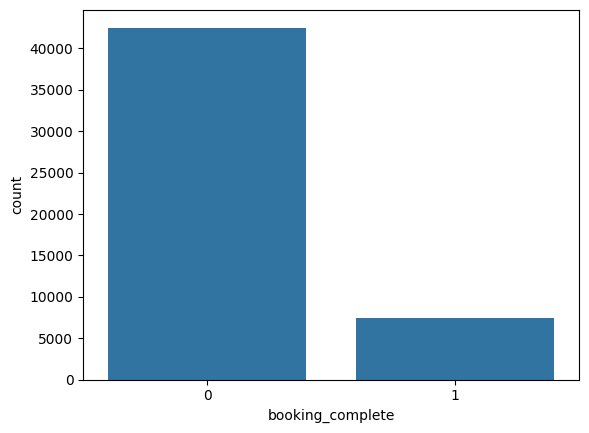

In [11]:
sns.countplot(x="booking_complete", data=df)

## Split Data for Modeling

In [12]:
X = df.drop("booking_complete", axis=1)  # Features
y = df["booking_complete"]               # Target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
X_train.to_csv("data/X_train.csv", index=False)
y_train.to_csv("data/y_train.csv", index=False)

## Train a Machine Learning Model
Recommended Algorithm: RandomForest (provides feature importance for insights).

In [14]:
# Initialize and train the model
model = RandomForestClassifier(random_state=42, class_weight="balanced")  # Handles imbalance
model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

Why RandomForest?

Handles non-linear relationships.

Outputs feature importance (critical for business insights).

## Evaluate Model Performance
Use metrics suitable for imbalanced data (since only ~15% bookings are "complete"):

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.98      0.92      8520
           1       0.55      0.12      0.20      1480

    accuracy                           0.85     10000
   macro avg       0.71      0.55      0.56     10000
weighted avg       0.82      0.85      0.81     10000

ROC-AUC Score: 0.7851097972972974


<Axes: >

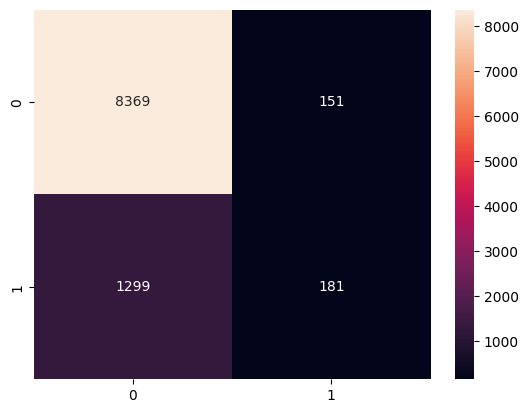

In [15]:
# Predictions
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]  # Probabilities for AUC

# Metrics
print("Classification Report:\n", classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_proba))

# Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d")

## Key Metrics to Report:

Precision: % of predicted bookings that were correct.

Recall: % of actual bookings correctly predicted.

ROC-AUC: Model’s ability to distinguish classes (aim for >0.8).

## Interpret Feature Importance
Visualize Top Predictors:

Text(0.5, 1.0, 'Top 10 Features Influencing Booking Completion')

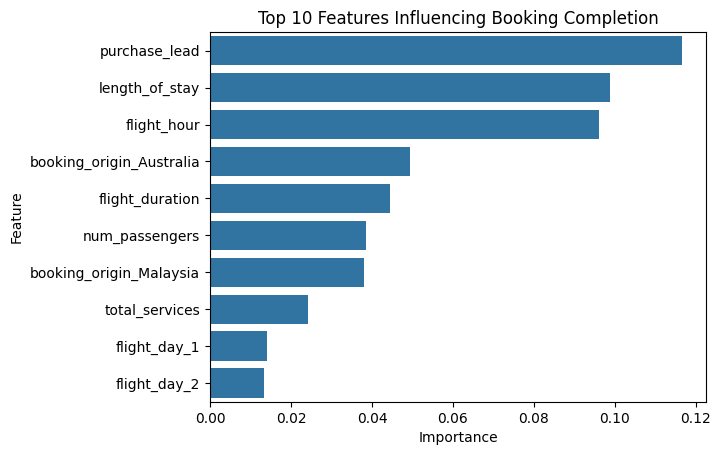

In [16]:
importances = model.feature_importances_
features = X_train.columns
feature_importance = pd.DataFrame({"Feature": features, "Importance": importances})
feature_importance = feature_importance.sort_values("Importance", ascending=False)

# Plot
sns.barplot(x="Importance", y="Feature", data=feature_importance.head(10))
plt.title("Top 10 Features Influencing Booking Completion")

## Business Insights:

Example: If purchase_lead is top, customers booking far in advance may need targeted offers.

## Cross-Validation (Robustness Check)

In [17]:
scores = cross_val_score(model, X_train, y_train, cv=5, scoring="roc_auc")
print("Cross-Validation ROC-AUC:", scores.mean())

Cross-Validation ROC-AUC: 0.7735270661571205


In [18]:
# Save as vector graphic (better for PowerPoint)
plt.savefig('booking_insights.svg', format='svg')

<Figure size 640x480 with 0 Axes>